# Process Stations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename

from climpyrical.gridding import scale_model_obs
from climpyrical.data import read_data
from climpyrical.cmd.find_matched_model_vals import add_model_values

### Load station data for processing

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# Parameters
name = "TJul97.5"
station_dv = "TJul2.5 (degC)"
station_path = "data/station_inputs/julT97.5p_allstations_v3_min8yr_for_maps.csv"
input_model_path = (
    "data/model_inputs/tas_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc"
)
medians = {"value": 28, "action": "add"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"


In [3]:
# Parameters cell

In [4]:
df = pd.read_csv(resource_filename("climpyrical", station_path), index_col=None)

Check the columns for standard names, and standardize them.

This process will not catch any and all possible inputs, so refer to documentation for 
expected column names

In [5]:
def check_df_columns(df):
    if 'longitude' in df.columns:
        df=df.rename(columns={'longitude': 'lon'})
    if 'long' in df.columns:
        df=df.rename(columns={'long': 'lon'})
    if 'latitude' in df.columns:
        df=df.rename(columns={'latitude': 'lat'})
    if 'name' in df.columns:
        df=df.rename(columns={'name': 'station_name'})
    if 'Name' in df.columns:
        df=df.rename(columns={'Name': 'station_name'})
    if "prov" in df.columns:
        df=df.rename(columns={"prov": "province"})
    if "elev" in df.columns:
        df=df.rename(columns={"elev": "elev (m)"})
    if "elevation (m)" in df.columns:
        df=df.rename(columns={"elevation (m)": "elev (m)"})
    return df

df = check_df_columns(df)
df.head(5)

if np.any(np.isnan(df[["lon", "lat", "elev (m)", station_dv]].values)):
    raise ValueError("NaN detected in station input file.")

Load preprocessed model at target resolution

In [6]:
ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

Perform unit conversion if necessary

Exclude suspect RL50 values with true 0.0

In [7]:
# calculate ratios with applied correction
# Note the ratios are calculated in K for Temperature fields
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Temperature DV detected in degC. Converitng to Kelvin")
    K = 273.15 # K
    df[station_dv] += K
    ds[dv] += K

if 'RL50 (kPa)' in station_dv:
    df = df[df[station_dv] != 0.0]

Temperature DV detected in degC. Converitng to Kelvin


Use matching script to find matching model values

In [8]:
df = add_model_values(ds=ds, df=df)
df.head(5)

INFO:root:Detect units: degC


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


,history_id,station_name,province,lon,lat,elev (m),TJul2.5 (degC),rlat,rlon,irlat,irlon,model_values
0,31.0,DISCOVERY ISLAND,BC,-123.226,48.4246,19,294.8500,3.813107,-17.091967,741,388,299.897353
1,42.0,ESQUIMALT HARBOUR,BC,-123.439,48.4320,3,294.5500,3.866425,-17.223366,742,385,299.641917
2,56.0,MALAHAT,BC,-123.530,48.5749,366,300.8500,4.021213,-17.233219,745,385,300.047842
3,90.0,SATURNA ISLAND CS,BC,-123.045,48.7839,24,298.1275,4.113871,-16.861279,747,394,301.363779
4,93.0,SHERINGHAM POINT,BC,-123.921,48.3767,7,293.1500,3.920432,-17.544312,743,378,298.922327


Group stations that land in the same index in rlat and rlon (land in the same grid cell)

This means that they are in the same grid cell and need to be aggregated

In [9]:
agg_dict = {
    station_dv: 'mean', 
    'rlat':'mean', 
    'rlon':'mean', 
    'lat': 'mean', 
    'lon': 'mean', 
    'elev (m)': 'mean',
    'station_name': 'first',
    'province': 'first',
    "model_values": "mean"
}

# Province key is used for WP10 and WP50 for
# special treatment of Atlantic/Far NW areas
if "province" not in df.columns:
    agg_dict = agg_dict.pop("province")

df_match = df.groupby(
    ['irlat', 'irlon'], as_index=False
).agg(
    agg_dict
)


irlat = df_match.irlat
irlon = df_match.irlon

In [10]:
df_match

,irlat,irlon,TJul2.5 (degC),rlat,rlon,lat,lon,elev (m),station_name,province,model_values
0,552,1011,303.85,-4.517790,10.457750,42.03330,-82.90000,191,HARROW CDA AUTO,ON,308.300051
1,552,1017,302.55,-4.549355,10.752628,41.94860,-82.51890,177,POINT PELEE CS,ON,308.016199
2,558,1009,305.02,-4.286849,10.373390,42.27560,-82.95560,190,WINDSOR A,ON,308.200850
3,565,1026,303.15,-3.968063,11.121350,42.45000,-81.88330,206,RIDGETOWN RCS,ON,307.318125
4,579,1046,303.85,-3.362845,11.999925,42.86670,-80.55000,232,DELHI CS,ON,306.650652
...,...,...,...,...,...,...,...,...,...,...,...
383,1207,549,289.25,24.460936,-9.983429,70.16670,-124.71700,87,CAPE PARRY A,NT,296.515335
384,1212,400,298.55,24.721682,-16.594914,67.57060,-139.83900,251,OLD CROW RCS,YT,293.432383
385,1215,1003,286.85,24.853381,10.112060,70.48470,-68.51670,27,CLYDE A COMPOSITE,NU,287.179768
386,1219,477,296.65,25.026504,-13.177940,69.43330,-133.01700,5,TUKTOYAKTUK,NT,296.207634


Verify that they are correlated

Text(0, 0.5, 'Model')

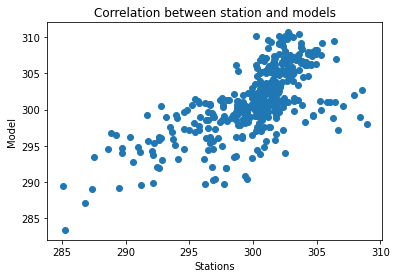

In [11]:
plt.scatter(df_match[station_dv], df_match.model_values)
plt.title("Correlation between station and models")
plt.xlabel('Stations')
plt.ylabel('Model')

Now each station should be matched with a value grid cell value

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that
$$\mu_s - \frac{\mu_m}{\beta} \approx 0$$ where $\mu_s$ is the spatial station mean and $\mu_m$ is the spatial model mean.

$\beta$ is simply:

$$\beta = \frac{\sum_i^{N_s}{M_i}}{\sum_i^{N_s}{S_i}}$$

In [12]:
ratio, best_tol = scale_model_obs(df_match.model_values, df_match[station_dv])
assert not np.any(np.isnan(ratio))
df_match = df_match.assign(ratio=ratio)
print("Scaling factor:", best_tol)

Scaling factor: 1.0040274186947018


In [13]:
df_match.head(3)

,irlat,irlon,TJul2.5 (degC),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,303.85,-4.517790,10.457750,42.0333,-82.9000,191,HARROW CDA AUTO,ON,308.300051,0.989535
1,552,1017,302.55,-4.549355,10.752628,41.9486,-82.5189,177,POINT PELEE CS,ON,308.016199,0.986209
2,558,1009,305.02,-4.286849,10.373390,42.2756,-82.9556,190,WINDSOR A,ON,308.200850,0.993665


In [14]:
# convert back to degC
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Temperature DV detected in degC. Converitng to Kelvin")
    K = 273.15 # K
    df_match[station_dv] -= K
    df_match.model_values -= K

Temperature DV detected in degC. Converitng to Kelvin


In [15]:
df_match.to_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), index=False
)

In [16]:
assert np.all(df_match['ratio'] >= 0)